### Les imports

##### génériques

In [24]:
import os
import io
import re
import pandas as pd
import numpy as np
import unicodedata
from tqdm import tqdm
import matplotlib.pyplot as plt

In [25]:
import sklearn
from sklearn import metrics
from sklearn_crfsuite import CRF, metrics

##### tensorflows

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import plot_model

In [27]:
try:
    from jyquickhelper import add_notebook_menu 
except:
    !pip install jyquickhelper
    from jyquickhelper import add_notebook_menu

In [28]:
add_notebook_menu()

## I. Une approche simple avec des réseaux de neurones récurrents

### I.a Le dataset


Le dataset est composée de phrases en anglais pour lesquelles certains mots sont labélisés. 

Les labels sont :

 * personnes (**PER**), 
 * lieux (**LOC**) 
 * organisations (**ORG**)
 * autres (**O**)
 
 

In [29]:
'''
Le fichier texte contenant les données est structuré de la sorte :

- Une ligne contient un mot ainsi que ces labels
- Les phrases sont séparées d'une ligne blanche

ex : 

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O


_read_dataset lit le dataset en paramètre et stocke les phrases dans une liste, sous la forme d'un tuple (mots,position_tag,ner_tag)
'''
def _read_dataset(filepath):
        with open(filepath, encoding="utf-8") as f:
            sent = []
            for line in f:
                if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                    if sent:
                        yield sent
                        sent = []
                else:
                    splits = line.split(" ")
                    token = splits[0]
                    pos_tag = splits[1]
                    ner_tag = splits[3].rstrip()
                    if 'MISC' in ner_tag:
                        ner_tag = 'O'
                    
                    sent.append((token, pos_tag, ner_tag))

In [30]:
train_sents = list(_read_dataset('NER Dataset/train.txt'))
test_sents = list(_read_dataset('NER Dataset/test.txt'))

### I.b Prepocessing

In [31]:
# reduced features
def reduced_word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'w':word.lower(),
    }
    
    return sent[i][0].lower()

In [32]:
'''
renvoie la liste des features (mots) de la phrase en paramètre
'''
def sent2features(sent):
    return [reduced_word2features(sent, i) for i in range(len(sent))]

'''
renvoie la liste des labels de la phrase en paramètre
'''
def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [33]:
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

On a besoin de connaître la taille de la plus longue phrase du dataset lorsqu'on va construire l'embedding

In [34]:
def lengths(data):
    return max([len(sent) for sent in data])

max_length = lengths(X_train)
max_length

113

In [35]:
max_length = 20

X_vectorizer = TextVectorization(standardize=None,
                                 split="whitespace",
                                 output_mode="int",
                                 output_sequence_length=max_length)

x_ = [' '.join(sent) for sent in X_train]
X_vectorizer.adapt(x_)
X_train_enc = X_vectorizer(x_)

x_ = [' '.join(sent) for sent in X_test]
X_test_enc = X_vectorizer(x_)

In [36]:
vocabulary = X_vectorizer.get_vocabulary()

In [37]:
y_vectorizer = TextVectorization(standardize=None,
                                 split="whitespace",
                                 output_mode="int",
                                 output_sequence_length=max_length)

x_ = [' '.join(sent) for sent in y_train]
y_vectorizer.adapt(x_)
y_train_enc = y_vectorizer(x_)

x_ = [' '.join(sent) for sent in y_test]
y_test_enc = y_vectorizer(x_)

In [38]:
labels = y_vectorizer.get_vocabulary()
labels

['', '[UNK]', 'O', 'B-LOC', 'B-PER', 'B-ORG', 'I-PER', 'I-ORG', 'I-LOC']

### I.c Modèle *Baseline*

In [39]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

try: # https://stackoverflow.com/questions/66059532/attributeerror-crf-object-has-no-attribute-keep-tempfiles
    crf.fit(X_train, y_train)
except AttributeError:
    pass

In [40]:
y_pred = crf.predict(X_test)
labels_list = list(crf.classes_)

In [41]:
metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels_list)

0.8055111833833511

In [42]:
print(metrics.flat_classification_report(y_test, y_pred, labels=sorted(labels_list)[3:6], digits=3))

              precision    recall  f1-score   support

       I-LOC      0.163     0.027     0.047       257
       I-ORG      0.102     0.032     0.049       834
       I-PER      0.404     0.176     0.246      1156

   micro avg      0.293     0.106     0.156      2247
   macro avg      0.223     0.079     0.114      2247
weighted avg      0.264     0.106     0.150      2247



#### Observations

Le modèle *baseline* n'est pas performant. Son score F1 de 0.80 s'explique par le fait qu'il classe la plupart des mots dans le label 'O' (other), et étant donné que la majorité des mots du dataset sont classé dans 'O', alors le score F1 pondéré est élevé. 

En revanche, cela ne traduit pas le fait d'être performant. En effet, le modèle ne sait pas classer les mots qui ne sont pas 'O'. Le score f1 de LOC est 0.05, de ORG est de 0.05 et de PER de 0.25. 

In [43]:
result = {
    "baseline" : [0.150,0.047,0.049,0.246],
    "RNN" : [],
    "attention" : []
}

## II. Modèle NER avec Bi-LSTM


Dans cette partie, nous tenterons d'améliorer les résultats du modèle en ajoutant une couche BI-RNN.

En effet, pour classer un mot dans une phrase, il est parfois nécessaire de connaître le contexte de ce mot. Par exemple, dans les phrases "I eat an apple" et "I went to an apple store to buy a phone", les mots "apple" sont des homonymes. Ils ont la même syntaxe mais n'ont pas le même sens. 

Les réseaux récurrents bidirectionnelles permettent d'avoir des inputs sur les séquences précédentes et les séquences suivantes d'un mot. Ainsi, le modèle peut classer un mot en ayant une idée du contexte.



### II Le modèle

 

In [44]:
# Constants
vocab_size = len(vocabulary)
nb_labels = len(labels)

max_len = max_length  # Sequence length to pad the outputs to.
embedding_dim = 50
lstm_hidden = 100

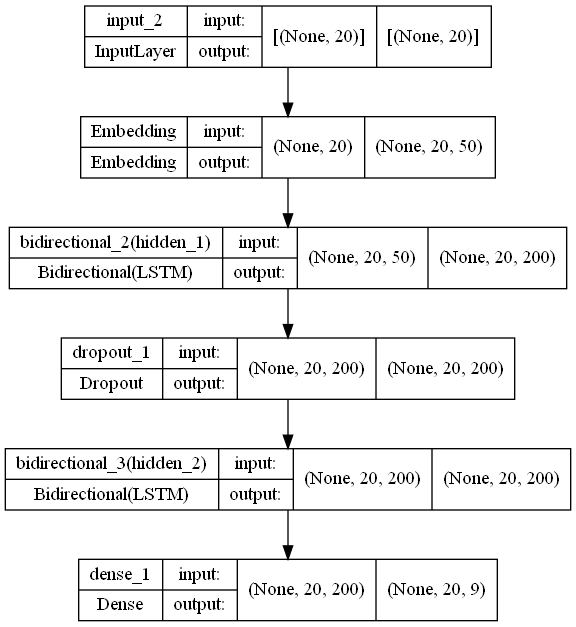

In [45]:
# define the model
input_ = layers.Input(shape=(max_length,), dtype=tf.int32)

x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="Embedding")(input_)

x = layers.Bidirectional(layers.LSTM(lstm_hidden, return_sequences=True, name="hidden_1"))(x)

x = layers.Dropout(0.2)(x)

x = layers.Bidirectional(layers.LSTM(lstm_hidden,return_sequences=True,name="hidden_2"))(x)

output_ = layers.Dense(nb_labels, activation='softmax')(x)

model_NER_Bi_RNN = Model(input_, output_)
# summarize the model
plot_model(model_NER_Bi_RNN, show_shapes=True, expand_nested=True)

In [46]:
callbacks_list = [EarlyStopping(monitor='val_accuracy', min_delta=0.0005, patience=10, verbose=1, mode='max', restore_best_weights=True)
                 ]

model_NER_Bi_RNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist_NER_Bi_RNN = model_NER_Bi_RNN.fit(X_train_enc, y_train_enc, validation_split=0.2,
                 epochs=1000, batch_size=250, callbacks=callbacks_list, verbose=1)

Epoch 1/1000
45/45 [==============================] - 21s 348ms/step - loss: 0.9234 - accuracy: 0.7212 - val_loss: 0.4318 - val_accuracy: 0.9059
Epoch 2/1000
45/45 [==============================] - 15s 341ms/step - loss: 0.4084 - accuracy: 0.9029 - val_loss: 0.3871 - val_accuracy: 0.9142
Epoch 3/1000
45/45 [==============================] - 14s 318ms/step - loss: 0.3666 - accuracy: 0.9069 - val_loss: 0.3579 - val_accuracy: 0.9147
Epoch 4/1000
45/45 [==============================] - 21s 477ms/step - loss: 0.3334 - accuracy: 0.9076 - val_loss: 0.3363 - val_accuracy: 0.9165
Epoch 5/1000
45/45 [==============================] - 23s 504ms/step - loss: 0.3042 - accuracy: 0.9094 - val_loss: 0.3074 - val_accuracy: 0.9181
Epoch 6/1000
45/45 [==============================] - 15s 333ms/step - loss: 0.2689 - accuracy: 0.9146 - val_loss: 0.2664 - val_accuracy: 0.9237
Epoch 7/1000
45/45 [==============================] - 11s 249ms/step - loss: 0.1915 - accuracy: 0.9385 - val_loss: 0.2064 - val_ac

In [47]:
def _babysit_model(hist):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

    pd.DataFrame({'val_loss':hist.history['val_loss'],
              'loss':hist.history['loss'],
             }).plot(ax=ax1)
    pd.DataFrame({'val_accuracy':hist.history['val_accuracy'],
              'accuracy':hist.history['accuracy']
             }).plot(ax=ax2)

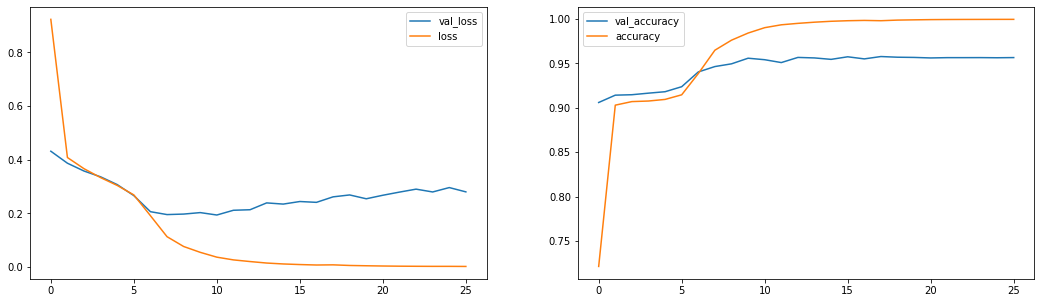

In [48]:
_babysit_model(hist_NER_Bi_RNN)

In [52]:
labels = ['[PAD]']+labels[1:]
labels_id = [i for i, _ in enumerate(labels)]

(['[PAD]', '[UNK]', 'O', 'B-LOC', 'B-PER', 'B-ORG', 'I-PER', 'I-ORG', 'I-LOC'],
 [0, 1, 2, 3, 4, 5, 6, 7, 8])

In [53]:
from sklearn import metrics

y_pred_enc = model_NER_Bi_RNN.predict(X_test_enc)
y_pred_enc = np.argmax(y_pred_enc, axis=2)

metrics.f1_score((y_test_enc.numpy()).flatten(), y_pred_enc.flatten(), average='weighted')

0.9451099628983979

In [54]:
print(metrics.classification_report((y_test_enc.numpy()).flatten(), y_pred_enc.flatten(),
                                    target_names=["LOC", "PER", "ORG"], labels=labels_id[3:], digits=3))

              precision    recall  f1-score   support

         LOC      0.620     0.777     0.690      1436
         PER      0.886     0.400     0.551      1363
         ORG      0.657     0.633     0.645      1464

   micro avg      0.584     0.568     0.576      6101
   macro avg      0.601     0.562     0.529      6101
weighted avg      0.683     0.568     0.584      6101



C:\Users\alexi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:2148: UserWarning: labels size, 6, does not match size of target_names, 3
  warnings.warn(


### II.b Conclusion

En moyenne, on obtient un f1 score similaire pour les deux modèles. (Pour le modèle *baselin*, le f1-score pondéré est de 0.597, pour le modèle amélioré, il est de 0.607)

En revanche, lorsqu'on regarde dans le détail, on remarque que les f1-score de chaque classe ont sensiblement changé. En effet, pour les lieux et les personnes, notre modèle est un peu moins performant. Mais pour les organisations, il s'est amélioré, en passant d'un f1-score de 0.53 à 0.65. 

Une explication à cette observation est que les organisations peuvent avoir des noms qui sont des homonymes (cf : exemple avec apple). Ainsi, le modèle arrive plus facilement à les classer en connaissant le contexte.

In [55]:
result["RNN"] = [0.584,0.690, 0.551, 0.645]

# III. Modèle RNN avec mécanisme d'attention


Le mécanisme d'attention repose sur l'idée que la traduction d'une phrase vers une autre ne se fait pas mot à mot, mais en pensant continuellement au sens de la phrase d'origine. 

Ainsi, les mécanismes d'attention permettent de donner au décoder, à chaque étape de la traduction, une distribution de l'ensemble des états cachés de l'encoder. 

Les mécanismes d'attention permettent entre autre de faire de la traduction, mais également de la reconnaissance d'entités nommées. Nous allons dans cette partie dévelloper un modèle NER avec mécanisme d'attention

### III.a Le modèle

Soit n = max_length
    m = lstm_hidden


Pour créer l'attention :

       - On applique une couche Dense avec activation linéaire sur la sortie du réseau récurrent. On a donc une matrice de taille (n x m ) 
       - La fonction de score est un produit matricielle entre les états de la couche LSTM et la sortie de cette couche Dense.
       - Le résultat de cette fonction de score est de taille (n*n)
       - On applique ensuite une couche d'activation pour déterminer les poids. Cette activation est une fonction softmax. On obtient ainsi l'attention l'ensemble des poids de l'attention.
       - On calcule la somme des états du RNN pondérée avec les coefficients calculés dans la couche précédente. Cette opération est un produit matricielle.
       - On obtient ainsi le contexte. 
       - On concatenne le contexte avec la sortie de la couche Dense.
       

       


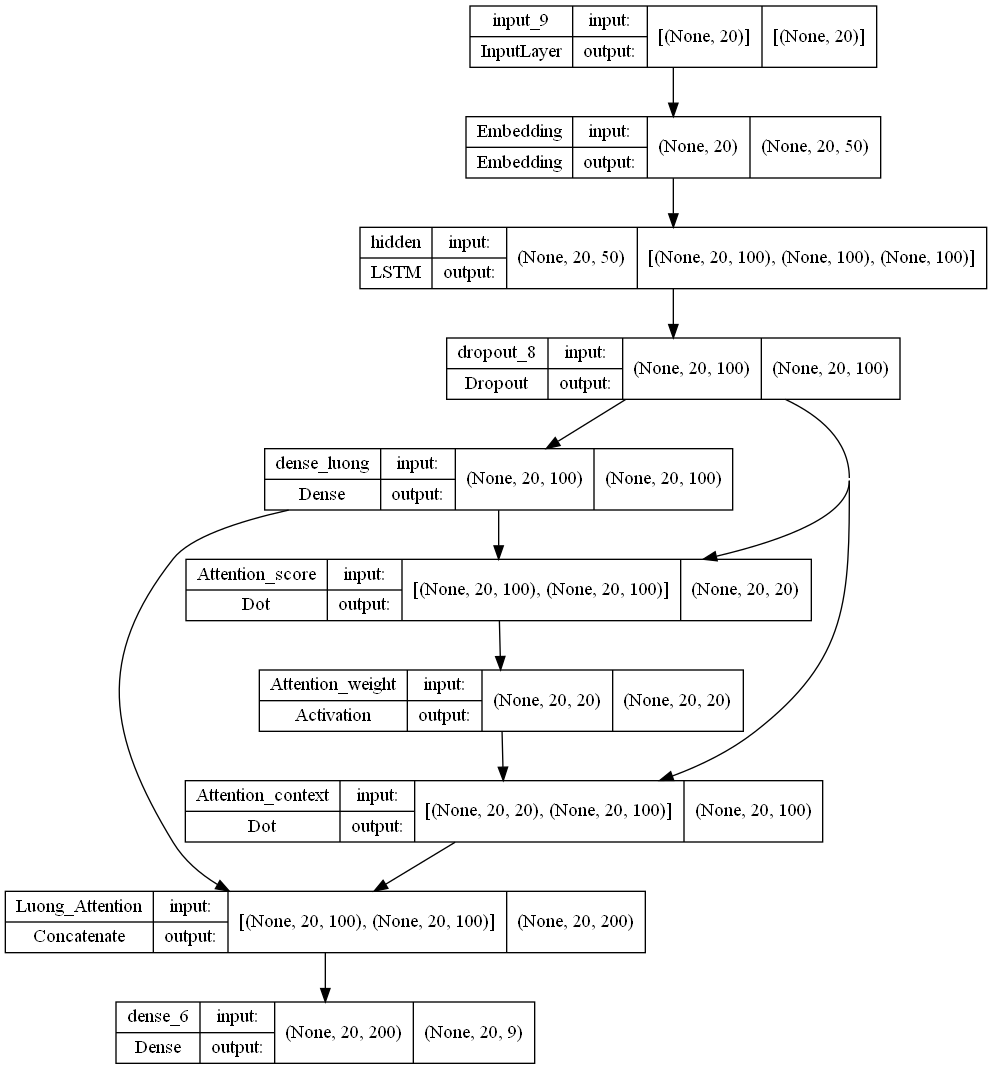

In [67]:
# define the model
input_ = layers.Input(shape=(max_length,), dtype=tf.int32)

x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, name="Embedding")(input_)


x,x_h,x_c = layers.LSTM(lstm_hidden,return_sequences=True,return_state=True,name="hidden")(x)
x = layers.Dropout(0.2)(x)

x_input_activation = layers.Dense(lstm_hidden,activation='linear',name="dense_luong")(x)

attention = layers.dot([x_input_activation, x], axes=[2,2], name="Attention_score")
attention = layers.Activation('softmax', name="Attention_weight")(attention)

context = layers.dot([attention, x], axes=[2,1], name="Attention_context")

_combined_context = layers.concatenate([context, x_input_activation], name="Luong_Attention")


output_ = layers.Dense(nb_labels, activation='softmax')(_combined_context)

model_NER_attention = Model(input_, output_)
# summarize the model
plot_model(model_NER_attention, show_shapes=True, expand_nested=True)

In [68]:
callbacks_list = [EarlyStopping(monitor='val_accuracy', min_delta=0.0005, patience=10, verbose=1, mode='max', restore_best_weights=True)
                 ]

model_NER_attention.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist_NER_attention = model_NER_attention.fit(X_train_enc, y_train_enc, validation_split=0.2,
                 epochs=1000, batch_size=250, callbacks=callbacks_list, verbose=1)

Epoch 1/1000
45/45 [==============================] - 10s 92ms/step - loss: 1.1940 - accuracy: 0.7129 - val_loss: 0.5733 - val_accuracy: 0.8962
Epoch 2/1000
45/45 [==============================] - 5s 108ms/step - loss: 0.4693 - accuracy: 0.8897 - val_loss: 0.3935 - val_accuracy: 0.9101
Epoch 3/1000
45/45 [==============================] - 4s 94ms/step - loss: 0.3701 - accuracy: 0.9037 - val_loss: 0.3460 - val_accuracy: 0.9146
Epoch 4/1000
45/45 [==============================] - 4s 90ms/step - loss: 0.3149 - accuracy: 0.9071 - val_loss: 0.2972 - val_accuracy: 0.9154
Epoch 5/1000
45/45 [==============================] - 4s 92ms/step - loss: 0.2495 - accuracy: 0.9101 - val_loss: 0.2469 - val_accuracy: 0.9209
Epoch 6/1000
45/45 [==============================] - 4s 91ms/step - loss: 0.1945 - accuracy: 0.9270 - val_loss: 0.2312 - val_accuracy: 0.9299
Epoch 7/1000
45/45 [==============================] - 4s 90ms/step - loss: 0.1600 - accuracy: 0.9465 - val_loss: 0.2134 - val_accuracy: 0.93

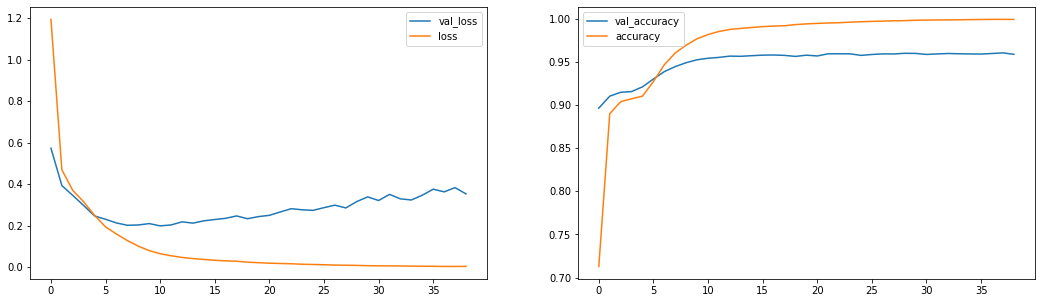

In [69]:
_babysit_model(hist_NER_attention)

In [70]:
y_pred_enc = model_NER_attention.predict(X_test_enc)
y_pred_enc = np.argmax(y_pred_enc, axis=2)
labels = ['[PAD]']+labels[1:]
labels_id = [i for i, _ in enumerate(labels)]

metrics.f1_score((y_test_enc.numpy()).flatten(), y_pred_enc.flatten(), average='weighted')

0.9501784146863861

In [71]:
print(metrics.classification_report((y_test_enc.numpy()).flatten(), y_pred_enc.flatten(),
                                    target_names=["LOC", "PER", "ORG"], labels=labels_id[3:], digits=3))

              precision    recall  f1-score   support

         LOC      0.776     0.787     0.781      1436
         PER      0.899     0.492     0.636      1363
         ORG      0.689     0.597     0.640      1464

   micro avg      0.709     0.598     0.649      6101
   macro avg      0.683     0.591     0.613      6101
weighted avg      0.750     0.598     0.651      6101



C:\Users\alexi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:2148: UserWarning: labels size, 6, does not match size of target_names, 3
  warnings.warn(


### III.b Conclusion

C'est avec le mécanisme d'attention qu'on obtient le modèle avec les meilleurs résultats lorsqu'on veut faire de la reconnaissance d'entitées nommées. 

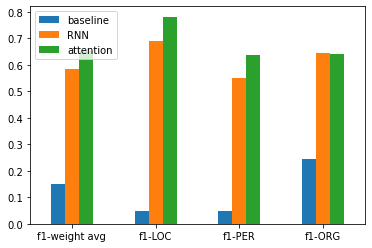

In [72]:
result["attention"] = [0.651,0.781, 0.636, 0.640]
index = ['f1-weight avg', 'f1-LOC', 'f1-PER','f1-ORG']

df = pd.DataFrame(result, index=index)
ax = df.plot.bar(rot=0)